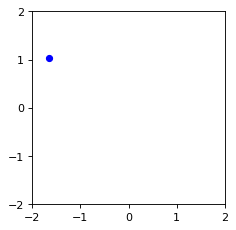

In [33]:
import numpy as np
import math
import matplotlib.pyplot as plt
from IPython import display
from numpy import linalg as LA

#get acceleration based on each particle.
def getAcc(N, ps, m, softening):
    a = np.zeros((N,2))
    for i in range(N):
        for k in range(N):
            for j in range(2):
                if (k != i):
                    a[i][j] += 6.67*10**(-11)*m[k]*(ps[k][j] - ps[i][j])*(softening + (ps[i][1] - ps[k][1])**2 + (ps[i][0] - ps[k][0])**2)**(-3/2)
    return a

#create and fill up a distance matrix
def distance(pos, N):
    
    dist = np.zeros((N,N));
    
    for i in range(N):
        for j in range(N):
                dist[i][j] = ((pos[i][1] - pos[j][1])**2 + (pos[i][0] - pos[j][0])**2)**(0.5);

    for i in range(N):
        dist[i][i] = max(dist[i]);

    return dist;

#modify a particle's position if its "inside" of another particle
def psmod(pos, dist, N, r):
    
    sr = 2*r;
    
    for i in range(N):
        
        dist2 = dist;
        
        while (min(dist2[i]) < sr):
            j = np.argmin(dist2[i]);
            
            x0 = pos[i][0];
            y0 = pos[i][1];
            
            m = (y0 - pos[j][1])/(x0 - pos[j][0]);
            b = y0 - m*x0;
            
            cons = 1;
            if pos[j][0] < x0:
                cons = -1;
            
            x = (-b*m + x0 + m*y0 + cons*(-b**2 + sr**2 + (m*sr)**2 - 2*b*m*x0 - (m*x0)**2 + 2*b*y0 + 2*m*x0*y0 - y0**2)**(1/2))/(m**2 + 1);
            y = m*x + b;
            
            pos[j][0] = x;
            pos[j][1] = y;
            
            dist2 = np.delete(dist2,j,1);
    
    return pos;
            
#check if a particle has collided with another particle        
def colcheck(dist, N, r):
    
    boolean = np.zeros((N,1));
    sr = 2*r;
    
    for i in range(N):
        if (min(dist[i]) <= sr):
            boolean[i] = 1;
        
    return boolean;
            

def main():
    """ N-body simulation """
    
    # Simulation parameters
    N         = 10    
    t         = 0      
    tf      = 5.0   
    dt        = 0.01   
    softening = 10    
    Nt = int(np.ceil(tf/dt));
    r = 0.075;
    plotRealTime = True 
    
    m = 10**(5) * np.ones((N,1));
    ps  = np.random.randn(N,2);   
    vl  = np.random.randn(N,2);
    
    # calculate initial accelerations
    a = getAcc(N, ps, m, softening )
    
    # prep figure
    plt.ion();
    fig = plt.figure(figsize=(4,5), dpi=80)
    grid = plt.GridSpec(3, 1, wspace=0.0, hspace=0.3)
    ax1 = plt.subplot(grid[0:2,0])
    
    for i in range(Nt):
    
        dist = distance(ps, N);
        
        ps = psmod(ps, dist, N, r);
        
        dist = distance(ps, N);
        
        b = colcheck(dist, N, r);
        
        for i in range(N):
            #calculate new velocities if a collision occurs
            if b[i] == 1:
                j = np.argmin(dist[i]);

                px = m[i]*vl[i][0] + m[j]*vl[j][0];
                ax = m[i]*(1 + m[i]/m[j]);
                bx = -2*px*m[i]/m[j];
                cx = px**2/m[j] - m[i]*(m[i]*vl[i][0]**2 + m[j]*vl[j][0]**2)/m[j];
                
                cons1 = -1;
                if np.sign(vl[j][0]) >= 0:
                    cons1 = 1;
                
                v1x = (-bx + cons1*(bx**2 - 4*ax*cx)**(1/2))/(2*ax);
                v2x = (px - m[i]*v1x)/m[j];
                
                py = m[i]*vl[i][1] + m[j]*vl[j][1];
                ay = m[i]*(1 + m[i]/m[j]);
                by = -2*py*m[i]/m[j];
                cy = py**2/m[j] - m[i]*(m[i]*vl[i][1]**2 + m[j]*vl[j][1]**2)/m[j];
                
                cons2 = -1;
                if np.sign(vl[j][1]) >= 0:
                    cons2 = 1;
                    
                v1y = (-by + cons2*(by**2 - 4*ay*cy)**(1/2))/(2*ay);
                v2y = (py - m[i]*v1y)/m[j];
                
                vl[i][0] = v1x;
                vl[j][0] = v2x;
                vl[i][1] = v1y;
                vl[j][1] = v2y;
                
                vl[i] += a[i] * dt/2.0

                ps[i] += vl[i] * dt
                
            else:

                vl[i] += a[i] * dt/2.0

                ps[i] += vl[i] * dt

        # update accelerations
        a = getAcc(N, ps, m, softening)

        vl += a * dt/2.0

        # update time
        t += dt
        
        dist = distance(ps, N);
        
        ps = psmod(ps, dist, N, r);
        
        # plot in real time
        if plotRealTime or (i == Nt-1):
            plt.sca(ax1)
            plt.cla()
            
            plt.scatter(ps[:,0],ps[:,1],s=30,color='blue')
            ax1.set(xlim=(-2, 2), ylim=(-2, 2))
            ax1.set_aspect('equal', 'box')
            ax1.set_xticks([-2,-1,0,1,2])
            ax1.set_yticks([-2,-1,0,1,2])
            
            display.display(plt.gcf())
            display.clear_output(wait=True)
            fig.canvas.draw();
            fig.canvas.flush_events();
#             plt.pause(0.001);
            
           
    
    return 0
  
if __name__== "__main__":
  main()